# **$Hydrogen$ $Wave$ $Function$**


**Hydrogen Wave function projected in 2 Dimensinal  $xy$-plane**

In [8]:

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib.figure import figaspect

from scipy.special import sph_harm, genlaguerre, factorial
# use atomic units (a0 = 1) for numerical evaluation below
a0 = 1.0

plt.style.use('dark_background')
mpl.rcParams['mathtext.fontset'] = 'cm'


def cart2sphe(x, y, z):
    '''
    3D Cartesian coordinates to spherical coordinates.

    input:
        x, y, z : numpy arrays
    '''
    xy2     = x**2 + y**2
    r       = np.sqrt(xy2 + z**2)
    theta   = np.arctan2(np.sqrt(xy2), z) # the polar angle in radian angles
    phi     = np.arctan2(y, x)            # the azimuth angle in radian angles
    phi[phi < 0] += np.pi * 2             # np.arctan2 returns the angle in the range [-pi, pi]

    return r, theta, phi


################################################################################
if __name__ == "__main__":
    Nmax = 6
    nlms  = [
        (n, l, m)
        for n in range(1, Nmax+1)
        for l in range(n)
        for m in range(l+1)
    ]

    # Numeric hydrogen wavefunctions using scipy.special (avoids sympy import issues)
    def radial_R(n, l, r):
        # r : numpy array or scalar (in atomic units)
        rho = 2.0 * r / (n * a0)
        prefac = np.sqrt((2.0 / (n * a0))**3 * factorial(n - l - 1) / (2.0 * n * factorial(n + l)))
        L = genlaguerre(n - l - 1, 2 * l + 1)
        return prefac * np.exp(-rho / 2.0) * rho**l * L(rho)

    def psi_nlm_numeric(n, l, m, r_arr, phi_arr, theta_arr):
        # sph_harm takes arguments (m, l, phi, theta)
        R = radial_R(n, l, r_arr)
        Y = sph_harm(m, l, phi_arr, theta_arr)
        return R * Y

    # Create callable PSI functions matching previous call signature PSI[ii](r, phi, theta)
    PSI = [
        (lambda n=n, l=l, m=m: (lambda r, phi, theta: psi_nlm_numeric(n, l, m, r, phi, theta)))()
        for n, l, m in nlms
    ]

    print(figaspect(2 / Nmax))
    fig = plt.figure(
        #figsize=(9.6, 4.8),
        figsize=figaspect(2 / Nmax),
        dpi=300,
        constrained_layout=True
    )
    axes_array = np.zeros((Nmax, (Nmax*(Nmax+1))//2), dtype=int)
    axes_id    = 0
    for ii in range(Nmax):
        lm_sum = ((ii+1) * (ii+2)) // 2
        for jj in range(0, lm_sum):
            axes_id += 1
            axes_array[ii, -(jj+1)] = axes_id

    axes = fig.subplot_mosaic(
        axes_array.tolist(),
        empty_sentinel=0,
    )
    axes = [axes[ii+1] for ii in range(len(axes))]

    cut_planes = np.ones(len(axes), dtype=int) * 2
    ################################################################################

    for ii in range(len(axes)):
        n, l, m = nlms[ii]

        # L       = np.ceil(integrate(R_nl(n, l, r, Z=1)**2 * r**3, (r, 0, oo)) / 10) * 10
        # L       = integrate(R_nl(n, l, r, Z=1)**2 * r**3, (r, 0, oo)) * 2
        # N       = 100
        # print(n, l, L)

        if n == 1:
            L, N = 1.5*n**2 + 1.0, 100
        else:
            L, N = 1.5*n**2 + 5.0, 100

        a0, b0 = np.mgrid[
            -L:L:N*1j,
            -L:L:N*1j
        ]
        nx, ny = a0.shape
        xyz_planes_sphe = [
            cart2sphe(a0, b0, 0),
            cart2sphe(0, a0, b0),
            cart2sphe(a0, 0, b0),
        ]

        ax = axes[ii]
        ax.set_aspect(1.0)

        r0, theta, phi = xyz_planes_sphe[cut_planes[ii]]
        wfc = PSI[ii](r0, phi, theta).reshape(nx, ny)
        ax.pcolormesh(a0, b0, np.abs(wfc), cmap='magma')
       #plasma, inferno, magma, cividis
        ax.set_xlim(-L, L)
        ax.set_ylim(-L, L)

        STEP = 5
        if n == 1:
            ax.set_xticks([-2.5, 2.5])
            ax.set_yticks([-2.5, 2.5])
            ax.xaxis.set_minor_locator(AutoMinorLocator(n=2))
            ax.yaxis.set_minor_locator(AutoMinorLocator(n=2))
        else:
            ax.set_xticks([-x for x in np.arange(0, L, STEP)] + [x for x in np.arange(0, L, STEP)])
            ax.set_yticks([-x for x in np.arange(0, L, STEP)] + [x for x in np.arange(0, L, STEP)])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        ax.text(0.05, 0.05, "({}, {}, {})".format(n, l, m),
                fontsize='xx-small',
                ha='left', va='bottom', transform=ax.transAxes, color='w')

    fig.text(0.0, 0.80,  r'$ \Psi_{nlm}(r,\theta,\phi) = \sqrt{ \left(\frac{2}{na_0}\right)^3\, \frac{(n-l-1)!}{2n[(n+l)!]} } e^{-r / na_0} \left(\frac{2r}{na_0}\right)^l L_{n-l-1}^{2l+1}\cdot Y_l^m(\theta, \phi)$',
            fontsize='26',
            ha='left', va='top', transform=fig.transFigure, color='w')

    fig.text(0.00, 0.59,  " $ a_0 = (4 \pi \epsilon_0 \hbar^2)(m_e e^2)^{-1}=0.529$ ${\AA} m $.\n $n=1,2,3,...$; $l=0,1,2,3,...,n-1$; $m=-l,-l+1,...,0,...,l-1,l.$ ",
            fontsize='12',
            linespacing=1.5,
            ha='left', va='top', transform=fig.transFigure, color='w')

    plt.savefig('hydro_wfc.png')
    plt.show()

<>:139: SyntaxWarning: invalid escape sequence '\p'
<>:139: SyntaxWarning: invalid escape sequence '\p'
C:\Users\ASUS\AppData\Local\Temp\ipykernel_12272\727024196.py:139: SyntaxWarning: invalid escape sequence '\p'
  fig.text(0.00, 0.59,  " $ a_0 = (4 \pi \epsilon_0 \hbar^2)(m_e e^2)^{-1}=0.529$ ${\AA} m $.\n $n=1,2,3,...$; $l=0,1,2,3,...,n-1$; $m=-l,-l+1,...,0,...,l-1,l.$ ",


ImportError: DLL load failed while importing _multiarray_umath: The specified module could not be found.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_12272\727024196.py:139: SyntaxWarning: invalid escape sequence '\p'
  fig.text(0.00, 0.59,  " $ a_0 = (4 \pi \epsilon_0 \hbar^2)(m_e e^2)^{-1}=0.529$ ${\AA} m $.\n $n=1,2,3,...$; $l=0,1,2,3,...,n-1$; $m=-l,-l+1,...,0,...,l-1,l.$ ",


ImportError: initialization failed

In [5]:
#!/usr/bin/env python

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

from sympy import lambdify, integrate, oo
from sympy.abc import r, theta, phi
from sympy.physics.hydrogen import R_nl, Psi_nlm

plt.style.use('dark_background')
mpl.rcParams['mathtext.fontset'] = 'cm'


def cart2sphe(x, y, z):
    '''
    3D Cartesian coordinates to spherical coordinates.

    input:
        x, y, z : numpy arrays
    '''
    xy2     = x**2 + y**2
    r       = np.sqrt(xy2 + z**2)
    theta   = np.arctan2(np.sqrt(xy2), z) # the polar angle in radian angles
    phi     = np.arctan2(y, x)            # the azimuth angle in radian angles
    phi[phi < 0] += np.pi * 2             # np.arctan2 returns the angle in the range [-pi, pi]

    return r, theta, phi


################################################################################
if __name__ == "__main__":
    Nmax = 4
    nlms  = [
        (n, l, m)
        for n in range(1, Nmax+1)
        for l in range(n)
        for m in range(l+1)
    ]
    PSI  = [
        lambdify((r, phi, theta), Psi_nlm(n, l, m, r, phi, theta), 'numpy')
        for n, l, m in nlms
    ]

    ################################################################################
    # print(plt.figaspect(2 / Nmax),)
    fig = plt.figure(
        figsize=(9.6, 4.8),
        # figsize=plt.figaspect(2 / Nmax),
        dpi=300,
        constrained_layout=True
    )

    axes_array = np.zeros((Nmax, (Nmax*(Nmax+1))//2), dtype=int)
    axes_id    = 0
    for ii in range(Nmax):
        lm_sum = ((ii+1) * (ii+2)) // 2
        for jj in range(0, lm_sum):
            axes_id += 1
            axes_array[ii, -(jj+1)] = axes_id

    axes = fig.subplot_mosaic(
        axes_array.tolist(),
        empty_sentinel=0,
    )
    axes = [axes[ii+1] for ii in range(len(axes))]

    cut_planes = np.ones(len(axes), dtype=int) * 2
    ################################################################################

    for ii in range(len(axes)):
        n, l, m = nlms[ii]

        # L       = np.ceil(integrate(R_nl(n, l, r, Z=1)**2 * r**3, (r, 0, oo)) / 10) * 10
        # L       = integrate(R_nl(n, l, r, Z=1)**2 * r**3, (r, 0, oo)) * 2
        # N       = 100
        # print(n, l, L)

        if n == 1:
            L, N = 1.5*n**2 + 1.0, 100
        else:
            L, N = 1.5*n**2 + 5.0, 100

        a0, b0 = np.mgrid[
            -L:L:N*1j,
            -L:L:N*1j
        ]
        nx, ny = a0.shape
        xyz_planes_sphe = [
            cart2sphe(a0, b0, 0),
            cart2sphe(0, a0, b0),
            cart2sphe(a0, 0, b0),
        ]

        ax = axes[ii]
        ax.set_aspect(1.0)

        r0, theta, phi = xyz_planes_sphe[cut_planes[ii]]
        wfc = PSI[ii](r0, phi, theta).reshape(nx, ny)
        ax.pcolormesh(a0, b0, np.abs(wfc), cmap='viridis')

        ax.set_xlim(-L, L)
        ax.set_ylim(-L, L)

        STEP = 5
        if n == 1:
            ax.set_xticks([-2.5, 2.5])
            ax.set_yticks([-2.5, 2.5])
            ax.xaxis.set_minor_locator(AutoMinorLocator(n=2))
            ax.yaxis.set_minor_locator(AutoMinorLocator(n=2))
        else:
            ax.set_xticks([-x for x in np.arange(0, L, STEP)] + [x for x in np.arange(0, L, STEP)])
            ax.set_yticks([-x for x in np.arange(0, L, STEP)] + [x for x in np.arange(0, L, STEP)])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        ax.text(0.05, 0.05, "({}, {}, {})".format(n, l, m),
                fontsize='xx-small',
                ha='left', va='bottom', transform=ax.transAxes, color='w')


    fig.text(0.0, 1.00,  r'$Hydrogen$ $Wave$ $Function$',
            fontsize=28,
            ha='left', va='top', transform=fig.transFigure, color='w')

    fig.text(0.0, 0.90,  r'$Probability$ $Density$',
            fontsize=20,
            ha='left', va='top', transform=fig.transFigure, color='w')

    fig.text(0.0, 0.80,  r'$ \psi_{nlm}(r,\theta,\phi) = \sqrt{ \left(\frac{2}{na_0}\right)^3\, \frac{(n-l-1)!}{2n[(n+l)!]} } e^{-r / na_0} \left(\frac{2r}{na_0}\right)^l L_{n-l-1}^{2l+1}\cdot Y_l^m(\theta, \phi)$',
            fontsize='xx-large',
            ha='left', va='top', transform=fig.transFigure, color='w')

    # fig.text(0.00, 0.64,  "NOTE:\n\t1. The distance between two major ticks in the plot is $5\,a_0$,\n\t2. The number in the braces are the three quantum numbers $(n, l, m)$",
    #         fontsize='small',
    #         linespacing=1.8,
    #         ha='left', va='top', transform=fig.transFigure, color='w')

    fig.text(0.00, 0.64,  "NOTE:",
            fontsize='small',
            ha='left', va='top', transform=fig.transFigure, color='w')

    fig.text(0.00, 0.59,  "    1. The distance between two major ticks in the plot is $5\,a_0$, \n        where $a_0 = (4 \pi \epsilon_0 \hbar^2)(m_e e^2)^{-1}=0.529$ ${\AA} m $.\n    2. The numbers in the brace are the three quantum numbers $(n,\,l,\,m)$ \n    3. $n$ is pricipal quantum number, $n=1,2,3,...$\n        $l$ is orbital quantum number, $l=0,1,2,3,...,n-1$\n        $m$ is magnetic quantum number, $m=-l,-l+1,...,0,...,l-1,l.$ ",
            fontsize='small',
            linespacing=1.5,
            ha='left', va='top', transform=fig.transFigure, color='w')

    plt.savefig('hydro_wfc.png')

    # from subprocess import call
    # call('feh -xdF hydro_wfc.png'.split())

<>:144: SyntaxWarning: invalid escape sequence '\,'
<>:144: SyntaxWarning: invalid escape sequence '\,'
C:\Users\ASUS\AppData\Local\Temp\ipykernel_12272\4171578130.py:144: SyntaxWarning: invalid escape sequence '\,'
  fig.text(0.00, 0.59,  "    1. The distance between two major ticks in the plot is $5\,a_0$, \n        where $a_0 = (4 \pi \epsilon_0 \hbar^2)(m_e e^2)^{-1}=0.529$ ${\AA} m $.\n    2. The numbers in the brace are the three quantum numbers $(n,\,l,\,m)$ \n    3. $n$ is pricipal quantum number, $n=1,2,3,...$\n        $l$ is orbital quantum number, $l=0,1,2,3,...,n-1$\n        $m$ is magnetic quantum number, $m=-l,-l+1,...,0,...,l-1,l.$ ",


ImportError: DLL load failed while importing _multiarray_umath: The specified module could not be found.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_12272\4171578130.py:144: SyntaxWarning: invalid escape sequence '\,'
  fig.text(0.00, 0.59,  "    1. The distance between two major ticks in the plot is $5\,a_0$, \n        where $a_0 = (4 \pi \epsilon_0 \hbar^2)(m_e e^2)^{-1}=0.529$ ${\AA} m $.\n    2. The numbers in the brace are the three quantum numbers $(n,\,l,\,m)$ \n    3. $n$ is pricipal quantum number, $n=1,2,3,...$\n        $l$ is orbital quantum number, $l=0,1,2,3,...,n-1$\n        $m$ is magnetic quantum number, $m=-l,-l+1,...,0,...,l-1,l.$ ",


ImportError: initialization failed

NameError: name 'r_mesh' is not defined

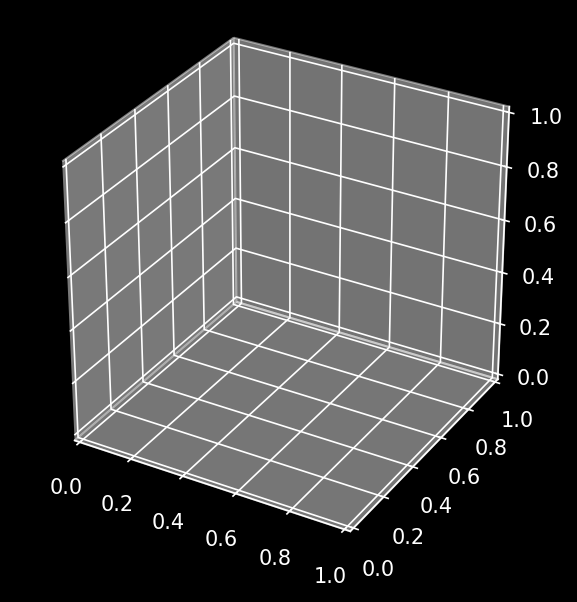

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import lambdify
from sympy.abc import r, theta, phi
from sympy.physics.hydrogen import Psi_nlm
from mpl_toolkits.mplot3d import Axes3D

def sphe2cart(r, theta, phi):
    """
    Spherical coordinates to 3D Cartesian coordinates.
    input: r, theta, phi : numpy arrays
    """
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

# Setting up the quantum numbers for n=1,2 and all possible l, m
quantum_numbers = [
    (1, 0, 0),  # n=1, l=0, m=0
    (2, 0, 0),  # n=2, l=0, m=0
    (2, 1, -1), # n=2, l=1, m=-1
    (2, 1, 0),  # n=2, l=1, m=0
    (2, 1, 1),   # n=2, l=1, m=1
    (3, 0, 0),   # n=3, l=0, m=0
    (3, 1, -1),  # n=3, l=1, m=-1
    (3, 1, 0),   # n=3, l=1, m=0
    (3, 1, 1),   # n=3, l=1, m=1
    (3, 2, -2),  # n=3, l=2, m=-2
    (3, 2, -1),  # n=3, l=2, m=-1
    (3, 2, 0),   # n=3, l=2, m=0
    (3, 2, 1),   # n=3, l=2, m=1
    (3, 2, 2)   # n=3, l=2, m=2
]

# Generate the corresponding wave functions
PSI = [
    lambdify((r, phi, theta), Psi_nlm(n, l, m, r, phi, theta), 'numpy')
    for n, l, m in quantum_numbers
]
grid_size = (3, 5)  # Arranging the plots in a 3x5 grid

# Set up the figure for multiple 3D subplots
fig = plt.figure(figsize=(18, 12), dpi=150, constrained_layout=True)

# Loop over the quantum number combinations and create plots
for idx, (n, l, m) in enumerate(quantum_numbers):
    ax = fig.add_subplot(grid_size[0], grid_size[1], idx + 1, projection='3d')
    ax.set_box_aspect([1, 1, 1])  # Aspect ratio is 1:1:1

    # Calculate the wave function for the current quantum numbers
    wfc = PSI[idx](r_mesh, phi_mesh, theta_mesh)

    # Convert spherical coordinates to Cartesian coordinates
    x_mesh, y_mesh, z_mesh = sphe2cart(r_mesh, theta_mesh, phi_mesh)

    # Normalize the wave function for better visualization
    wfc_abs = np.abs(wfc)
    wfc_abs /= wfc_abs.max()

    # Use scatter plot for 3D visualization
    ax.scatter(x_mesh, y_mesh, z_mesh, c=wfc_abs, cmap='magma', marker='o', s=1, alpha=0.1)

    # Set plot labels and title
    ax.set_title(f'n={n}, l={l}, m={m}', fontsize=12, color='w')
    ax.set_xlabel('x', fontsize=10)
    ax.set_ylabel('y', fontsize=10)
    ax.set_zlabel('z', fontsize=10)

    # Set limits
    ax.set_xlim(-L, L)
    ax.set_ylim(-L, L)
    ax.set_zlim(-L, L)

# Overall plot title
fig.suptitle('3D Hydrogen Wave Function Probability Density', fontsize=16, color='w')
plt.show()




[12.   4.8]


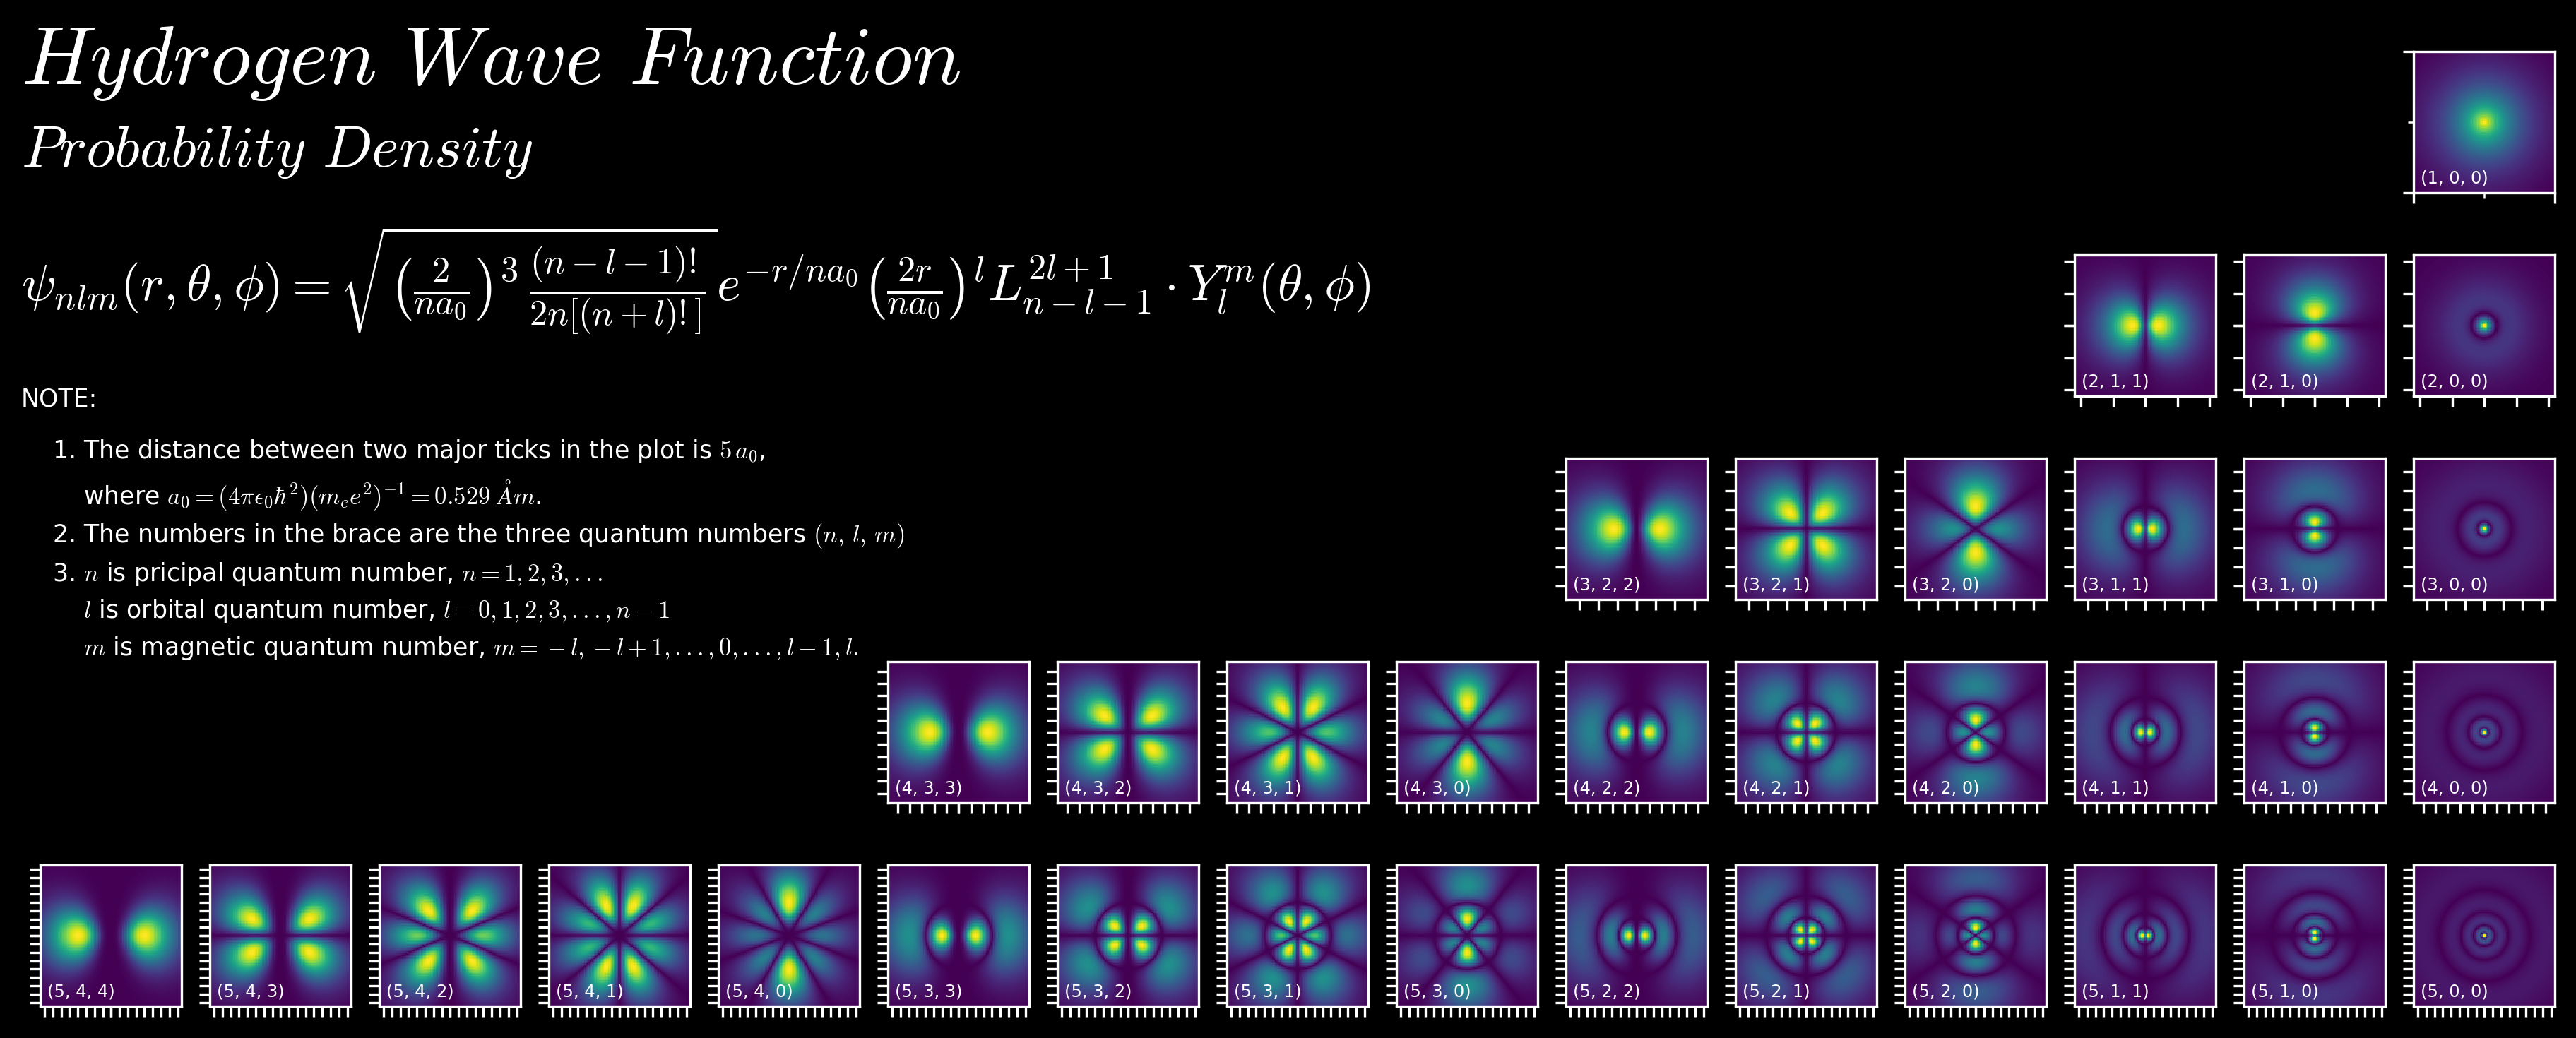

In [ ]:
#!/usr/bin/env python

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

from sympy import lambdify, integrate, oo
from sympy.abc import r, theta, phi
from sympy.physics.hydrogen import R_nl, Psi_nlm

plt.style.use('dark_background')
mpl.rcParams['mathtext.fontset'] = 'cm'


def cart2sphe(x, y, z):
    '''
    3D Cartesian coordinates to spherical coordinates.

    input:
        x, y, z : numpy arrays
    '''
    xy2     = x**2 + y**2
    r       = np.sqrt(xy2 + z**2)
    theta   = np.arctan2(np.sqrt(xy2), z) # the polar angle in radian angles
    phi     = np.arctan2(y, x)            # the azimuth angle in radian angles
    phi[phi < 0] += np.pi * 2             # np.arctan2 returns the angle in the range [-pi, pi]

    return r, theta, phi


################################################################################
if __name__ == "__main__":
    Nmax = 5
    nlms  = [
        (n, l, m)
        for n in range(1, Nmax+1)
        for l in range(n)
        for m in range(l+1)
    ]
    PSI  = [
        lambdify((r, phi, theta), Psi_nlm(n, l, m, r, phi, theta), 'numpy')
        for n, l, m in nlms
    ]

    ################################################################################
    print(plt.figaspect(2 / Nmax),)
    fig = plt.figure(
        #figsize=(9.6, 4.8),
        figsize=plt.figaspect(2 / Nmax),
        dpi=300,
        constrained_layout=True
    )

    axes_array = np.zeros((Nmax, (Nmax*(Nmax+1))//2), dtype=int)
    axes_id    = 0
    for ii in range(Nmax):
        lm_sum = ((ii+1) * (ii+2)) // 2
        for jj in range(0, lm_sum):
            axes_id += 1
            axes_array[ii, -(jj+1)] = axes_id

    axes = fig.subplot_mosaic(
        axes_array,
        empty_sentinel=0,
    )
    axes = [axes[ii+1] for ii in range(len(axes))]

    cut_planes = np.ones(len(axes), dtype=int) * 2
    ################################################################################

    for ii in range(len(axes)):
        n, l, m = nlms[ii]

        # L       = np.ceil(integrate(R_nl(n, l, r, Z=1)**2 * r**3, (r, 0, oo)) / 10) * 10
        # L       = integrate(R_nl(n, l, r, Z=1)**2 * r**3, (r, 0, oo)) * 2
        # N       = 100
        # print(n, l, L)

        if n == 1:
            L, N = 1.5*n**2 + 1.0, 100
        else:
            L, N = 1.5*n**2 + 5.0, 100

        a0, b0 = np.mgrid[
            -L:L:N*1j,
            -L:L:N*1j
        ]
        nx, ny = a0.shape
        xyz_planes_sphe = [
            cart2sphe(a0, b0, 0),
            cart2sphe(0, a0, b0),
            cart2sphe(a0, 0, b0),
        ]

        ax = axes[ii]
        ax.set_aspect(1.0)

        r0, theta, phi = xyz_planes_sphe[cut_planes[ii]]
        wfc = PSI[ii](r0, phi, theta).reshape(nx, ny)
        ax.pcolormesh(a0, b0, np.abs(wfc), cmap='viridis')

        ax.set_xlim(-L, L)
        ax.set_ylim(-L, L)

        STEP = 5
        if n == 1:
            ax.set_xticks([-2.5, 2.5])
            ax.set_yticks([-2.5, 2.5])
            ax.xaxis.set_minor_locator(AutoMinorLocator(n=2))
            ax.yaxis.set_minor_locator(AutoMinorLocator(n=2))
        else:
            ax.set_xticks([-x for x in np.arange(0, L, STEP)] + [x for x in np.arange(0, L, STEP)])
            ax.set_yticks([-x for x in np.arange(0, L, STEP)] + [x for x in np.arange(0, L, STEP)])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        ax.text(0.05, 0.05, "({}, {}, {})".format(n, l, m),
                fontsize='xx-small',
                ha='left', va='bottom', transform=ax.transAxes, color='w')

    fig.text(0.0, 1.00,  r'$Hydrogen$ $Wave$ $Function$',
            fontsize=28,
            ha='left', va='top', transform=fig.transFigure, color='w')

    fig.text(0.0, 0.90,  r'$Probability$ $Density$',
            fontsize=20,
            ha='left', va='top', transform=fig.transFigure, color='w')

    fig.text(0.0, 0.80,  r'$ \psi_{nlm}(r,\theta,\phi) = \sqrt{ \left(\frac{2}{na_0}\right)^3\, \frac{(n-l-1)!}{2n[(n+l)!]} } e^{-r / na_0} \left(\frac{2r}{na_0}\right)^l L_{n-l-1}^{2l+1}\cdot Y_l^m(\theta, \phi)$',
            fontsize='xx-large',
            ha='left', va='top', transform=fig.transFigure, color='w')

    # fig.text(0.00, 0.64,  "NOTE:\n\t1. The distance between two major ticks in the plot is $5\,a_0$,\n\t2. The number in the braces are the three quantum numbers $(n, l, m)$",
    #         fontsize='small',
    #         linespacing=1.8,
    #         ha='left', va='top', transform=fig.transFigure, color='w')

    fig.text(0.00, 0.64,  "NOTE:",
            fontsize='small',
            ha='left', va='top', transform=fig.transFigure, color='w')

    fig.text(0.00, 0.59,  "    1. The distance between two major ticks in the plot is $5\,a_0$, \n        where $a_0 = (4 \pi \epsilon_0 \hbar^2)(m_e e^2)^{-1}=0.529$ ${\AA} m $.\n    2. The numbers in the brace are the three quantum numbers $(n,\,l,\,m)$ \n    3. $n$ is pricipal quantum number, $n=1,2,3,...$\n        $l$ is orbital quantum number, $l=0,1,2,3,...,n-1$\n        $m$ is magnetic quantum number, $m=-l,-l+1,...,0,...,l-1,l.$ ",
            fontsize='small',
            linespacing=1.5,
            ha='left', va='top', transform=fig.transFigure, color='w')

    plt.savefig('hydro_wfc.png')

    # from subprocess import call
    # call('feh -xdF hydro_wfc.png'.split())

[14.4  4.8]


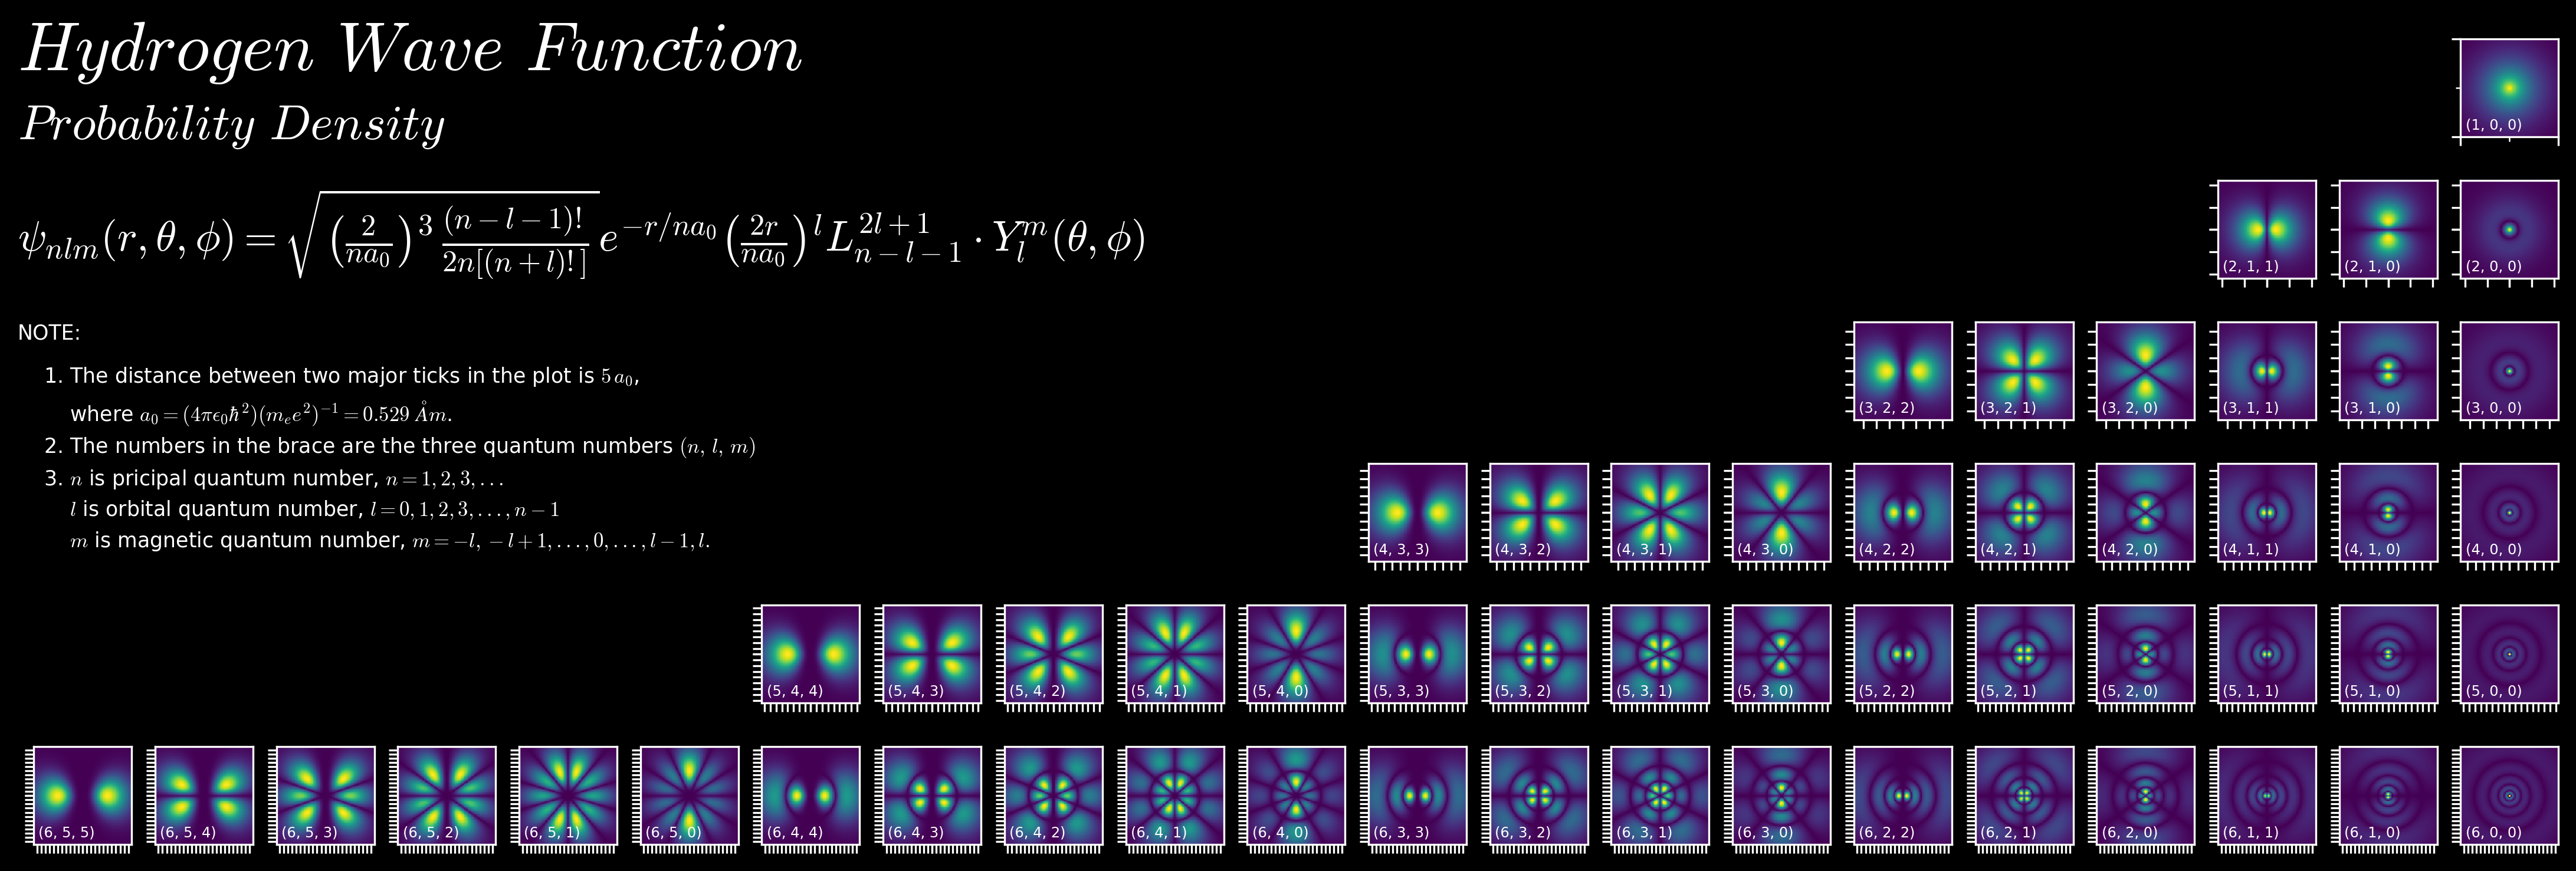

In [ ]:
#!/usr/bin/env python

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

from sympy import lambdify, integrate, oo
from sympy.abc import r, theta, phi
from sympy.physics.hydrogen import R_nl, Psi_nlm

plt.style.use('dark_background')
mpl.rcParams['mathtext.fontset'] = 'cm'


def cart2sphe(x, y, z):
    '''
    3D Cartesian coordinates to spherical coordinates.

    input:
        x, y, z : numpy arrays
    '''
    xy2     = x**2 + y**2
    r       = np.sqrt(xy2 + z**2)
    theta   = np.arctan2(np.sqrt(xy2), z) # the polar angle in radian angles
    phi     = np.arctan2(y, x)            # the azimuth angle in radian angles
    phi[phi < 0] += np.pi * 2             # np.arctan2 returns the angle in the range [-pi, pi]

    return r, theta, phi


################################################################################
if __name__ == "__main__":
    Nmax = 6
    nlms  = [
        (n, l, m)
        for n in range(1, Nmax+1)
        for l in range(n)
        for m in range(l+1)
    ]
    PSI  = [
        lambdify((r, phi, theta), Psi_nlm(n, l, m, r, phi, theta), 'numpy')
        for n, l, m in nlms
    ]

    ################################################################################
    print(plt.figaspect(2 / Nmax),)
    fig = plt.figure(
        #figsize=(9.6, 4.8),
        figsize=plt.figaspect(2 / Nmax),
        dpi=300,
        constrained_layout=True
    )

    axes_array = np.zeros((Nmax, (Nmax*(Nmax+1))//2), dtype=int)
    axes_id    = 0
    for ii in range(Nmax):
        lm_sum = ((ii+1) * (ii+2)) // 2
        for jj in range(0, lm_sum):
            axes_id += 1
            axes_array[ii, -(jj+1)] = axes_id

    axes = fig.subplot_mosaic(
        axes_array,
        empty_sentinel=0,
    )
    axes = [axes[ii+1] for ii in range(len(axes))]

    cut_planes = np.ones(len(axes), dtype=int) * 2
    ################################################################################

    for ii in range(len(axes)):
        n, l, m = nlms[ii]

        # L       = np.ceil(integrate(R_nl(n, l, r, Z=1)**2 * r**3, (r, 0, oo)) / 10) * 10
        # L       = integrate(R_nl(n, l, r, Z=1)**2 * r**3, (r, 0, oo)) * 2
        # N       = 100
        # print(n, l, L)

        if n == 1:
            L, N = 1.5*n**2 + 1.0, 100
        else:
            L, N = 1.5*n**2 + 5.0, 100

        a0, b0 = np.mgrid[
            -L:L:N*1j,
            -L:L:N*1j
        ]
        nx, ny = a0.shape
        xyz_planes_sphe = [
            cart2sphe(a0, b0, 0),
            cart2sphe(0, a0, b0),
            cart2sphe(a0, 0, b0),
        ]

        ax = axes[ii]
        ax.set_aspect(1.0)

        r0, theta, phi = xyz_planes_sphe[cut_planes[ii]]
        wfc = PSI[ii](r0, phi, theta).reshape(nx, ny)
        ax.pcolormesh(a0, b0, np.abs(wfc), cmap='viridis')

        ax.set_xlim(-L, L)
        ax.set_ylim(-L, L)

        STEP = 5
        if n == 1:
            ax.set_xticks([-2.5, 2.5])
            ax.set_yticks([-2.5, 2.5])
            ax.xaxis.set_minor_locator(AutoMinorLocator(n=2))
            ax.yaxis.set_minor_locator(AutoMinorLocator(n=2))
        else:
            ax.set_xticks([-x for x in np.arange(0, L, STEP)] + [x for x in np.arange(0, L, STEP)])
            ax.set_yticks([-x for x in np.arange(0, L, STEP)] + [x for x in np.arange(0, L, STEP)])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        ax.text(0.05, 0.05, "({}, {}, {})".format(n, l, m),
                fontsize='xx-small',
                ha='left', va='bottom', transform=ax.transAxes, color='w')

    fig.text(0.0, 1.00,  r'$Hydrogen$ $Wave$ $Function$',
            fontsize=28,
            ha='left', va='top', transform=fig.transFigure, color='w')

    fig.text(0.0, 0.90,  r'$Probability$ $Density$',
            fontsize=20,
            ha='left', va='top', transform=fig.transFigure, color='w')

    fig.text(0.0, 0.80,  r'$ \psi_{nlm}(r,\theta,\phi) = \sqrt{ \left(\frac{2}{na_0}\right)^3\, \frac{(n-l-1)!}{2n[(n+l)!]} } e^{-r / na_0} \left(\frac{2r}{na_0}\right)^l L_{n-l-1}^{2l+1}\cdot Y_l^m(\theta, \phi)$',
            fontsize='xx-large',
            ha='left', va='top', transform=fig.transFigure, color='w')

    # fig.text(0.00, 0.64,  "NOTE:\n\t1. The distance between two major ticks in the plot is $5\,a_0$,\n\t2. The number in the braces are the three quantum numbers $(n, l, m)$",
    #         fontsize='small',
    #         linespacing=1.8,
    #         ha='left', va='top', transform=fig.transFigure, color='w')

    fig.text(0.00, 0.64,  "NOTE:",
            fontsize='small',
            ha='left', va='top', transform=fig.transFigure, color='w')

    fig.text(0.00, 0.59,  "    1. The distance between two major ticks in the plot is $5\,a_0$, \n        where $a_0 = (4 \pi \epsilon_0 \hbar^2)(m_e e^2)^{-1}=0.529$ ${\AA} m $.\n    2. The numbers in the brace are the three quantum numbers $(n,\,l,\,m)$ \n    3. $n$ is pricipal quantum number, $n=1,2,3,...$\n        $l$ is orbital quantum number, $l=0,1,2,3,...,n-1$\n        $m$ is magnetic quantum number, $m=-l,-l+1,...,0,...,l-1,l.$ ",
            fontsize='small',
            linespacing=1.5,
            ha='left', va='top', transform=fig.transFigure, color='w')

    plt.savefig('hydro_wfc.png')

    # from subprocess import call
    # call('feh -xdF hydro_wfc.png'.split())